## Import all of our libraries necessary for prediction

In [1]:
## Try to do this from memory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler 
from sklearn.model_selection import cross_val_score, train_test_split,KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

## Load in our data

In [2]:
# Load train set
df_train = pd.read_csv('../project_2/all (1)/train.csv')

In [3]:
# Load test set
df_test = pd.read_csv('../project_2/all (1)/test.csv')

In [4]:
#Load output example
df_example_output = pd.read_csv('../project_2/all (1)/sample_sub_reg.csv')

## Baseline

In [5]:
df_train['SalePrice'].describe(include = 'all')

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [6]:
meany = df_train['SalePrice'] - 181469.70

In [7]:
meany.head()

0   -50969.7
1    38530.3
2   -72469.7
3    -7469.7
4   -42969.7
Name: SalePrice, dtype: float64

In [8]:
abs_meany =abs(meany)

In [9]:
## Mean absolue error --> Baseline
abs_meany.mean()

58358.94046806475

## Inspect and clean our data

# To do list

+ Switch numeric variables to strings
- Handle Nulls
    - 11 floats with nulls (look at how many are missing, consider median)
    - 15 strings with nulls. 
    - 6 variables have 1 missing so you may just have to delete an observation
    - A few that are grouped 
        -Garage Qual and Cond
        -Garage Cars and Area
        -Garage Yr Blt and Finish and Type
        -Bsmt Full Bath and Half Bath
 
- Do correlation analysis
- Analyse Describe method
-Dummy the data
-Normalize the data with a standard scalar

Convert these to 
Exterior Quality +
Exterior Condition +
Heating QC + 
KitchenQual +
Functional + 


In [10]:
# Look at column types and missing values
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

AttributeError: 'NoneType' object has no attribute 'head'

In [12]:
## Convert time metrics

df_train ['remodel age'] = 2010 - df_train['Year Remod/Add']
df_train = df_train.drop(['Year Remod/Add'], axis=1)

df_test ['remodel age'] = 2010 - df_test['Year Remod/Add']
df_test = df_test.drop(['Year Remod/Add'], axis=1)

In [13]:
#Create a variable for how old the house is
df_train['age'] = 2010 - df_train['Year Built']
df_train = df_train.drop(['Year Built'], axis=1)

df_test['age'] = 2010 - df_test['Year Built']
df_test = df_test.drop(['Year Built'], axis=1)

In [20]:
#Changing 
df_train['howlongagosold'] = 2010 - df_train['Yr Sold']
df_train =  df_train.drop(['Yr Sold'], axis=1)

df_test['howlongagosold'] = 2010 - df_test['Yr Sold']
df_test =df_test.drop(['Yr Sold'], axis=1)

In [14]:
df_train['Exter Qual'].value_counts()

TA    1247
Gd     697
Ex      81
Fa      26
Name: Exter Qual, dtype: int64

In [15]:
#Exter function
def Exterfunction(x):
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'TA':
        return 3
    elif x == 'Fa':
        return 2
    else:
        return 1

In [16]:
## Apply the Exter Function

df_train['Exter Qual'] = df_train['Exter Qual'].map(lambda x: Exterfunction(x))
df_train['Exter Cond'] = df_train['Exter Cond'].map(lambda x: Exterfunction(x))
df_train['Heating QC'] = df_train['Heating QC'].map(lambda x: Exterfunction(x))
df_train['Kitchen Qual'] = df_train['Kitchen Qual'].map(lambda x: Exterfunction(x))

df_test['Exter Qual'] = df_test['Exter Qual'].map(lambda x: Exterfunction(x))
df_test['Exter Cond'] = df_test['Exter Cond'].map(lambda x: Exterfunction(x))
df_test['Heating QC'] = df_test['Heating QC'].map(lambda x: Exterfunction(x))
df_test['Kitchen Qual'] = df_test['Kitchen Qual'].map(lambda x: Exterfunction(x))

In [17]:
df_train[['Exter Qual','Exter Cond','Heating QC','Kitchen Qual']].describe()

,Exter Qual,Exter Cond,Heating QC,Kitchen Qual
count,2051.000000,2051.000000,2051.000000,2051.000000
mean,3.406143,3.085812,4.158459,3.517309
std,0.587962,0.372792,0.964112,0.665577
min,2.000000,1.000000,1.000000,2.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,5.000000,3.000000
75%,4.000000,3.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [18]:
## Define the Functional Converstion

def FunctionalFunction(x):
    if x == 'Typ':
        return 8
    elif x == 'Min1':
        return 7
    elif x == 'Min2':
        return 6
    elif x == 'Mod':
        return 5
    elif x == 'Maj1':
        return 4
    elif x == 'Maj2':
        return 3
    elif x == 'Sev':
        return 2  
    else:
        return 1

In [19]:
Apply the functional Converstion

df_train['Functional'] = df_train['Functional'].map(lambda x: FunctionalFunction(x))
df_test['Functional'] = df_test['Functional'].map(lambda x: FunctionalFunction(x))

## Clean our Train Data

In [21]:
## Converting ints to objects for categorical data that will need to be dummified
df_train['Mo Sold'] = df_train['Mo Sold'].astype(str)
df_train['MS SubClass'] = df_train['MS SubClass'].astype(str)
df_train['Garage Yr Blt'] = df_train['Garage Yr Blt'].astype(str)

In [22]:
## Filling N/As
df_train['Lot Frontage']   = df_train['Lot Frontage'].fillna(df_train['Lot Frontage'].median())
df_train['Bsmt Half Bath'] = df_train['Bsmt Half Bath'] .fillna(0)
df_train['Bsmt Full Bath'] = df_train['Bsmt Full Bath']  .fillna(0)
df_train['Garage Cars']    = df_train['Garage Cars'].fillna(0)
df_train['BsmtFin SF 1']   = df_train['BsmtFin SF 1'].fillna(0)
df_train['Total Bsmt SF']  = df_train['Total Bsmt SF'] .fillna(0)
df_train['Garage Area']    = df_train['Garage Area'].fillna(0)
df_train['Alley']          = df_train['Alley'].fillna('No Alley Access')
df_train['Mas Vnr Type']   = df_train['Mas Vnr Type'].fillna('NA')
df_train['Mas Vnr Area']   = df_train['Mas Vnr Area'].fillna(0)
df_train['Bsmt Qual']      = df_train['Bsmt Qual'].fillna('NA')
df_train['Bsmt Cond']      = df_train['Bsmt Cond'].fillna('NA')
df_train['Bsmt Exposure']  = df_train['Bsmt Exposure'].fillna('NA')
df_train['BsmtFin Type 1'] = df_train['BsmtFin Type 1'].fillna('NA')
df_train['BsmtFin Type 2'] = df_train['BsmtFin Type 2'].fillna('NA')
df_train['BsmtFin SF 1']   = df_train['BsmtFin SF 1'].fillna('NA')
df_train['BsmtFin SF 2']   = df_train['BsmtFin SF 2'].fillna('NA')
df_train['Bsmt Unf SF']   = df_train['Misc Feature'].fillna('NA')
df_train['Fireplace Qu']   = df_train['Fireplace Qu'].fillna('NA')
df_train['Garage Type']    = df_train['Garage Type'].fillna('NA')
df_train['Garage Yr Blt']  = df_train['Garage Yr Blt'] .fillna('NA')
df_train['Garage Finish']  = df_train['Garage Finish'] .fillna('NA')
df_train['Garage Cond']    = df_train['Garage Cond'].fillna('NA')
df_train['Garage Qual']    = df_train['Garage Qual'].fillna('NA')
df_train['Pool QC']        = df_train['Pool QC'].fillna('NA')
df_train['Fence']          = df_train['Fence'].fillna('NA')
df_train['Misc Feature']   = df_train['Misc Feature'].fillna('NA')

In [23]:
df_train['MS Zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

In [24]:
df_train.describe(include='all')

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Sale Type,SalePrice,remodel age,age,howlongagosold
count,2051.000000,2.051000e+03,2051,2051,2051.000000,2051.000000,2051,2051,2051,2051,...,2051,2051,2051,2051.000000,2051,2051,2051.000000,2051.000000,2051.000000,2051.000000
unique,NaN,NaN,16,7,NaN,NaN,2,3,4,4,...,5,5,6,NaN,12,9,NaN,NaN,NaN,NaN
top,NaN,NaN,20,RL,NaN,NaN,Pave,No Alley Access,Reg,Lvl,...,NA,NA,NA,NaN,6,WD,NaN,NaN,NaN,NaN
freq,NaN,NaN,770,1598,NaN,NaN,2044,1911,1295,1843,...,2042,1651,1986,NaN,352,1781,NaN,NaN,NaN,NaN
mean,1474.033642,7.135900e+08,NaN,NaN,68.885422,10065.208191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,51.574354,NaN,NaN,181469.701609,25.809849,38.291078,2.224281
std,843.980841,1.886918e+08,NaN,NaN,21.309886,6742.488909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,573.393985,NaN,NaN,79258.659352,21.036250,30.177889,1.312014
min,1.000000,5.263011e+08,NaN,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,12789.000000,0.000000,0.000000,0.000000
25%,753.500000,5.284581e+08,NaN,NaN,60.000000,7500.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,129825.000000,6.000000,9.000000,1.000000
50%,1486.000000,5.354532e+08,NaN,NaN,68.000000,9430.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,162500.000000,17.000000,36.000000,2.000000
75%,2198.000000,9.071801e+08,NaN,NaN,78.000000,11513.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,214000.000000,45.500000,56.500000,3.000000


In [25]:
## Checking that there aren't any null variables.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null object
MS Zoning          2051 non-null object
Lot Frontage       2051 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st     

AttributeError: 'NoneType' object has no attribute 'head'

In [26]:
## Set our target train set

y_train= df_train['SalePrice']

In [27]:
## Set our explanatory variables
X_train = df_train.drop(columns=['Id','PID','SalePrice'], axis=1)

In [28]:
# Get Dummies
X_train = pd.get_dummies(X_train,drop_first=True)

In [29]:
## Isolate the ID column
ID_df = df_test['Id']

In [30]:
X_train.dtypes.head()

Lot Frontage    float64
Lot Area          int64
Overall Qual      int64
Overall Cond      int64
Mas Vnr Area    float64
dtype: object

In [31]:
X_train['Sale Type_CWD'].dtype

dtype('uint8')

In [32]:
X_train.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,BsmtFin SF 1,Total Bsmt SF,Heating QC,...,Mo Sold_8,Mo Sold_9,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,68.0,13517,6,8,289.0,4,3,533.0,725.0,5,...,0,0,0,0,0,0,0,0,0,1
1,43.0,11492,7,5,132.0,4,3,637.0,913.0,5,...,0,0,0,0,0,0,0,0,0,1
2,68.0,7922,5,7,0.0,3,4,731.0,1057.0,3,...,0,0,0,0,0,0,0,0,0,1
3,73.0,9802,5,5,0.0,3,3,0.0,384.0,4,...,0,0,0,0,0,0,0,0,0,1
4,82.0,14235,6,8,0.0,3,3,0.0,676.0,3,...,0,0,0,0,0,0,0,0,0,1


## Clean our Test Data

In [33]:
# Change types in our test data
df_test['Mo Sold'] = df_test['Mo Sold'].astype(str)
df_test['MS SubClass'] = df_test['MS SubClass'].astype(str)
df_test['Garage Yr Blt'] = df_test['Garage Yr Blt'].astype(str)

In [34]:
# Handle N/A's in our test data
df_test['Lot Frontage']   = df_test['Lot Frontage'].fillna(df_test['Lot Frontage'].median())
df_test['Bsmt Half Bath'] = df_test['Bsmt Half Bath'] .fillna(0)
df_test['Bsmt Full Bath'] = df_test['Bsmt Full Bath']  .fillna(0)
df_test['Garage Cars']    = df_test['Garage Cars'].fillna(0)
df_test['BsmtFin SF 1']   = df_test['BsmtFin SF 1'].fillna(0)
df_test['Total Bsmt SF']  = df_test['Total Bsmt SF'] .fillna(0)
df_test['Garage Area']    = df_test['Garage Area'].fillna(0)
df_test['Alley']          = df_test['Alley'].fillna('No Alley Access')
df_test['Mas Vnr Type']   = df_test['Mas Vnr Type'].fillna('NA')
df_test['Mas Vnr Area']   = df_test['Mas Vnr Area'].fillna(0)
df_test['Bsmt Qual']      = df_test['Bsmt Qual'].fillna('NA')
df_test['Bsmt Cond']      = df_test['Bsmt Cond'].fillna('NA')
df_test['Bsmt Exposure']  = df_test['Bsmt Exposure'].fillna('NA')
df_test['BsmtFin Type 1'] = df_test['BsmtFin Type 1'].fillna('NA')
df_test['BsmtFin Type 2'] = df_test['BsmtFin Type 2'].fillna('NA')
df_test['BsmtFin SF 1']   = df_test['BsmtFin SF 1'].fillna('NA')
df_test['BsmtFin SF 2']   = df_test['BsmtFin SF 2'].fillna('NA')
df_test['Bsmt Unf SF']   = df_test['Misc Feature'].fillna('NA')
df_test['Fireplace Qu']   = df_test['Fireplace Qu'].fillna('NA')
df_test['Garage Type']    = df_test['Garage Type'].fillna('NA')
df_test['Garage Yr Blt']  = df_test['Garage Yr Blt'] .fillna('NA')
df_test['Garage Finish']  = df_test['Garage Finish'] .fillna('NA')
df_test['Garage Cond']    = df_test['Garage Cond'].fillna('NA')
df_test['Garage Qual']    = df_test['Garage Qual'].fillna('NA')
df_test['Pool QC']        = df_test['Pool QC'].fillna('NA')
df_test['Fence']          = df_test['Fence'].fillna('NA')
df_test['Misc Feature']   = df_test['Misc Feature'].fillna('NA')

In [35]:
## Take our ID's out of our test set
X_test = df_test.drop(columns=['Id','PID'], axis=1)

In [36]:
# Get Dummies
X_test2 = pd.get_dummies(X_test,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

## Regularize and Train our First Model

In [37]:
#Regularize our data
ss= StandardScaler()

In [38]:
X_train_ss = ss.fit_transform(X_train)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
#Set up our lasso model
lasso = LassoCV(n_alphas=200)

In [40]:
## Check our R^2 score
cross_val_score(lasso,X_train_ss,y_train,cv=5).mean()

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You sho

0.8537601751882787

## Generate our missing dummy columns in test file, transform test file and prepare for prediction

In [41]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

## Code adjusted from https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

In [42]:
## Transform our test set
X_test_ss = ss.transform(X_test)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [43]:
## Fit our Lasso function to the training data
lasso.fit(X_train_ss,y_train)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

## Generate our predictions and output to a new file

In [44]:
# generate predictions using our Lasso model fit to our training data using the optimized alpha
pred = lasso.predict(X_test_ss)

In [45]:
# Make a dataframe column with our predicted prices
df_pred = pd.DataFrame(data=pred, columns=['SalePrice'])

In [46]:
# Concatenate the ID and SalePrice
output = pd.concat([ID_df,df_pred],axis=1)

In [47]:
## Output our first model
output.to_csv('~/Documents/predictions_DH_1.csv',sep=',')

# Check to see which terms were the most predictive


In [1]:
## Generate coefficients

Coefficients = list(lasso.coef_)

NameError: name 'lasso' is not defined

In [49]:
# Get out features
features = list(X_train.columns)

In [50]:
# Make into a dataframe
df_coef = pd.DataFrame([Coefficients], columns = features)


In [51]:
## Melt our columns
dfmelt = pd.melt(df_coef)

In [52]:
## Create an absolute value column
dfmelt['absvalue'] = np.abs(dfmelt.value)

In [53]:
dfmelt.sort_values('absvalue', ascending = False).head(40)

,variable,value,absvalue
13,Gr Liv Area,21325.162064,21325.162064
2,Overall Qual,13179.705604,13179.705604
92,Neighborhood_NridgHt,9037.729173,9037.729173
32,Misc Val,-7488.590907,7488.590907
34,age,-6167.475063,6167.475063
98,Neighborhood_StoneBr,5911.265943,5911.265943
5,Exter Qual,5729.737085,5729.737085
20,Kitchen Qual,5641.400338,5641.400338
24,Garage Cars,4694.333706,4694.333706
8,Total Bsmt SF,4675.775824,4675.775824


In [54]:
dfmelt_great_than_zero = dfmelt[dfmelt['absvalue']>0]

In [55]:
dfmelt_great_than_zero.shape

(121, 3)

In [56]:
dfmelt_great_than_zero.describe()

,value,absvalue
count,121.000000,1.210000e+02
mean,883.599462,1.755237e+03
std,3112.745754,2.714758e+03
min,-7488.590907,1.135205e-12
25%,-288.401130,1.754646e+02
50%,116.247424,7.931561e+02
75%,1739.358679,2.353011e+03
max,21325.162064,2.132516e+04


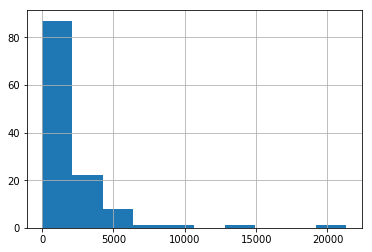

In [57]:
dfmelt_great_than_zero['absvalue'].hist()

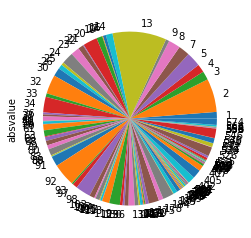

In [58]:
dfmelt_great_than_zero['absvalue'].plot.pie()

# We checked our output and it performed well! However, I think we can do better if we generate interactor terms. 

# Resource available discussing the order of operations in the preprocessing phase of ML

### https://medium.com/@samchaaa/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d

In [60]:
# Split the dummies out so I can polynomialize on just my continuous variables
# Decided to keep all of my dummies in for now, 
X_train_cont = X_train.loc[:, (X_train.dtypes == np.float64) | (X_train.dtypes == np.int64)]
X_train_categ = X_train.loc[:, (X_train.dtypes != np.float64) & (X_train.dtypes != np.int64)]


In [61]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X_train_cont)
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))


In [62]:
X_train_2= pd.concat([df_poly,X_train_categ],axis =1)

## Now that I have my polynomial coninuous features and dummies I need to normalize them.

In [63]:
ss2 = StandardScaler()

In [64]:
X_train_ss2 = ss2.fit_transform(X_train_2)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [65]:
#Set up our lasso model
lasso2 = LassoCV(n_alphas=200)

In [66]:
## Check our R^2 score
cross_val_score(lasso2,X_train_ss2,y_train,cv=5).mean()

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

## Generate our missing dummy columns in test file, transform test file and prepare for prediction

# Need to reshape and clean our test set

In [67]:
continuous_columns = list(X_train_cont.columns)
categorical_columns = list(X_train_categ.columns)

In [69]:
# Split the dummies out so I can polynomialize on just my continuous variables
# Decided to keep all of my dummies in for now, 
X_test_cont = X_test[continuous_columns]
X_test_categ = X_test[categorical_columns]


In [70]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X_test_cont)
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))


In [71]:
X_test_2= pd.concat([df_poly,X_test_categ],axis =1)

In [72]:
X_test_2.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,BsmtFin SF 1,Total Bsmt SF,Heating QC,...,Mo Sold_8,Mo Sold_9,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,69.0,9142.0,6.0,8.0,0.0,3.0,2.0,0.0,1020.0,4.0,...,0,0,0,0,0,0,0,0,0,1
1,68.0,9662.0,5.0,4.0,0.0,3.0,3.0,0.0,1967.0,3.0,...,1,0,0,0,0,0,0,0,0,1
2,58.0,17104.0,7.0,5.0,0.0,4.0,3.0,554.0,654.0,5.0,...,0,1,0,0,0,0,0,1,0,0
3,60.0,8520.0,5.0,6.0,0.0,4.0,3.0,0.0,968.0,3.0,...,0,0,0,0,0,0,0,0,0,1
4,68.0,9500.0,6.0,5.0,247.0,3.0,3.0,609.0,1394.0,4.0,...,0,0,0,0,0,0,0,0,0,1


In [73]:
X_train_2.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,BsmtFin SF 1,Total Bsmt SF,Heating QC,...,Mo Sold_8,Mo Sold_9,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,68.0,13517.0,6.0,8.0,289.0,4.0,3.0,533.0,725.0,5.0,...,0,0,0,0,0,0,0,0,0,1
1,43.0,11492.0,7.0,5.0,132.0,4.0,3.0,637.0,913.0,5.0,...,0,0,0,0,0,0,0,0,0,1
2,68.0,7922.0,5.0,7.0,0.0,3.0,4.0,731.0,1057.0,3.0,...,0,0,0,0,0,0,0,0,0,1
3,73.0,9802.0,5.0,5.0,0.0,3.0,3.0,0.0,384.0,4.0,...,0,0,0,0,0,0,0,0,0,1
4,82.0,14235.0,6.0,8.0,0.0,3.0,3.0,0.0,676.0,3.0,...,0,0,0,0,0,0,0,0,0,1


## Now that I have my polynomial coninuous features and dummies I need to normalize them.

In [74]:
X_test_2.shape

(879, 1243)

In [75]:
X_train_2.shape

(2051, 1243)

In [76]:
## Transform our test set
X_test_ss_2 = ss2.transform(X_test_2)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [77]:
## Fit our Lasso function to the training data
lasso2.fit(X_train_ss2,y_train)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

## Generate our predictions and output to a new file

In [78]:
# generate predictions using our Lasso model fit to our training data using the optimized alpha
pred = lasso2.predict(X_test_ss_2)

In [79]:
# Make a dataframe column with our predicted prices
df_pred = pd.DataFrame(data=pred, columns=['SalePrice'])

In [80]:
# Concatenate the ID and SalePrice
output = pd.concat([ID_df,df_pred],axis=1)

In [81]:
# Inspect
output.head()

,Id,SalePrice
0,2658,133912.589636
1,2718,167903.878940
2,2414,211767.534676
3,1989,119725.593045
4,625,184155.244432


In [82]:
## Output our first model
output.to_csv('~/Documents/predictions_DH_2.csv',sep=',')

# EDA to perform the log of skewed data

Text(0.5, 0, 'Price')

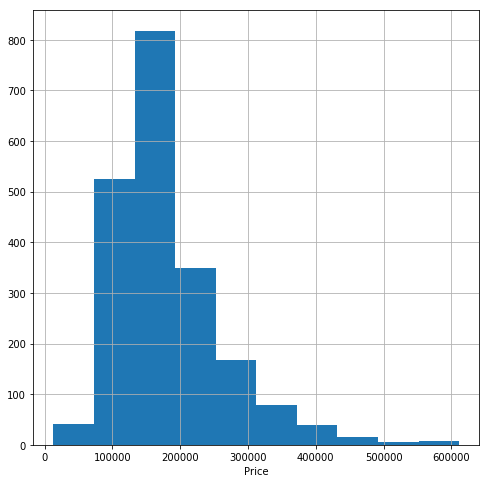

In [83]:
## Y is skewed
plt.figure(figsize=(8,8))
y_train.hist()
plt.xlabel('Price')


In [84]:
# make a log of y
y_train_log = np.log(y_train)

Text(0.5, 0, 'Price')

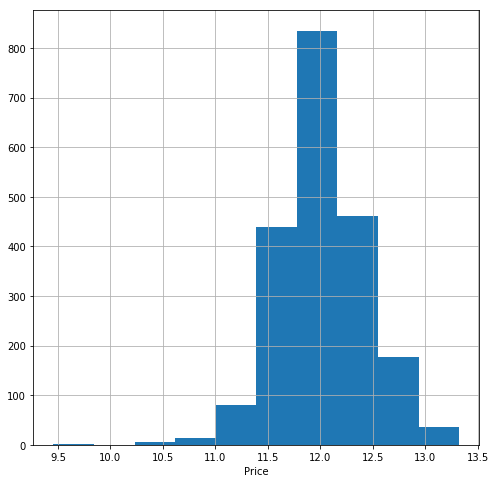

In [85]:
## It's now normally distributed
plt.figure(figsize=(8,8))
y_train_log.hist()
plt.xlabel('Price')

##Polynomialize our test and train

In [86]:
poly_3 = PolynomialFeatures(include_bias=False)
X_poly_3 = poly_3.fit_transform(X_train_cont)
df_poly_3 = pd.DataFrame(X_poly_3, columns=poly_3.get_feature_names(features))


In [87]:
X_poly_test = poly_3.transform(X_test_cont)
df_poly_test = pd.DataFrame(X_poly_test, columns=poly_3.get_feature_names(features))


In [88]:
df_poly_3.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,BsmtFin SF 1,Total Bsmt SF,Heating QC,...,Misc Val^2,Misc Val remodel age,Misc Val age,Misc Val howlongagosold,remodel age^2,remodel age age,remodel age howlongagosold,age^2,age howlongagosold,howlongagosold^2
0,68.0,13517.0,6.0,8.0,289.0,4.0,3.0,533.0,725.0,5.0,...,0.0,0.0,0.0,0.0,25.0,170.0,0.0,1156.0,0.0,0.0
1,43.0,11492.0,7.0,5.0,132.0,4.0,3.0,637.0,913.0,5.0,...,0.0,0.0,0.0,0.0,169.0,182.0,13.0,196.0,14.0,1.0
2,68.0,7922.0,5.0,7.0,0.0,3.0,4.0,731.0,1057.0,3.0,...,0.0,0.0,0.0,0.0,9.0,171.0,0.0,3249.0,0.0,0.0
3,73.0,9802.0,5.0,5.0,0.0,3.0,3.0,0.0,384.0,4.0,...,0.0,0.0,0.0,0.0,9.0,12.0,0.0,16.0,0.0,0.0
4,82.0,14235.0,6.0,8.0,0.0,3.0,3.0,0.0,676.0,3.0,...,0.0,0.0,0.0,0.0,289.0,1870.0,0.0,12100.0,0.0,0.0


##### To know which variables to take the log of see the following post
##### https://www.researchgate.net/post/What_is_the_acceptable_range_of_skewness_and_kurtosis_for_normal_distribution_of_data

## Set up my test and train data frames taking the logs 

In [89]:
#  from numpy import inf

In [90]:

# df_for_corr = pd.concat([df_poly_3,y_train_log],axis =1)

In [91]:
# # # TRAIN
# for i in list(df_poly_3.columns):
#     if np.abs(df_poly_3[i].skew()) >2:
#         df_poly_3[i] = df_poly_3[i]+1
#         df_poly_3[i] = df_poly_3[i].map(lambda x: np.log(x))
#         df_poly_3[i] = df_poly_3[i].replace(-inf,1)
        
#         # Replace inf with 0
# #         df_poly_3[i] = df_poly_3[i].replace(np.nan,np.log(median))
# #         print(np.log(median))

In [92]:
# # # TEST
# for i in list(df_poly_test.columns):
#     if np.abs(df_poly_test[i].skew()) >2:
# #         median=[]
# #         median = np.median(df_poly_test[i])
# #         print(median)
#         df_poly_test[i] = df_poly_test[i]+1
#         df_poly_test[i] = df_poly_test[i].map(lambda x: np.log(x))
#         df_poly_test[i] = df_poly_test[i].replace(-inf,1)
#         # Replace inf with 0
#         df_poly_test[i] = df_poly_test[i].replace(np.nan,np.log(median))

In [93]:
# for i in list(df_poly_test.columns):
#     empty = []
#     if np.abs(df_poly_test[i].skew()) >2:
#         empty = empty.append(i)

## Now that I have my polynomial continuous features and dummies I need to normalize them.

In [94]:
X_train_3= pd.concat([df_poly_3,X_train_categ],axis =1)

In [95]:
X_test_complete= pd.concat([df_poly_test,X_test_categ],axis =1)

In [96]:
ss3 = StandardScaler()

In [97]:
X_train_ss3 = ss3.fit_transform(X_train_3)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [98]:
X_test_ss3 = ss3.transform(X_test_complete)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [99]:
#Set up our lasso model
lasso3 = LassoCV(n_alphas=300)

In [100]:
## Check our R^2 score
cross_val_score(lasso3,X_train_ss3,y_train_log,cv=7)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You

KeyboardInterrupt: 

In [ ]:
y_train_log.describe()

In [ ]:
X_test_ss3.shape

In [ ]:
X_train_ss3.shape

## Test Data for Predictions

In [101]:
## Fit our Lasso function to the training data
lasso3.fit(X_train_ss3,y_train_log)

/Users/michaelhoppes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [102]:
lasso3.score(X_train_ss3, y_train_log)

0.9235096278036412

In [103]:
lasso3.alpha_

0.0066629291789848475

In [110]:
pred_test_train = lasso3.predict(X_train_ss3)
df_pred_train = pd.DataFrame(data=pred_test_train, columns=['SalePrice'])
y_train_price= y_train_log.apply(lambda x:np.e**(x))
y_train_pred= df_pred_train['SalePrice'].map(lambda x:np.e**(x))
mean_absolute_error(y_train_price,y_train_pred)


13439.041162795138

In [117]:
X_train_3.shape

(2051, 1243)

Text(0, 0.5, 'predicted price')

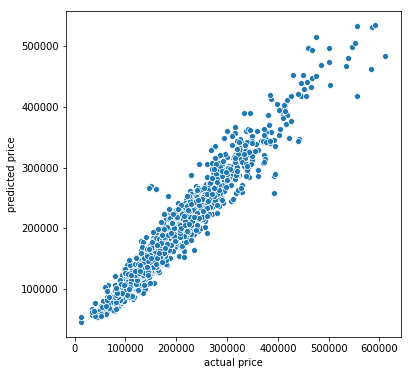

In [116]:
plt.figure(figsize=(6,6))
sns.scatterplot(y_train_price,y_train_pred)
plt.xlabel('actual price')
plt.ylabel('predicted price')

## Generate our predictions and output to a new file

In [ ]:
# generate predictions using our Lasso model fit to our training data using the optimized alpha
pred_test = lasso3.predict(X_test_ss3)

In [ ]:
# Make a dataframe column with our predicted prices
df_pred_test = pd.DataFrame(data=pred_test, columns=['SalePrice'])

In [ ]:
df_pred_test.describe()

In [ ]:
# Concatenate the ID and SalePrice
output_test = pd.concat([ID_df,df_pred_test],axis=1)

In [ ]:
# Inspect
output_test.head()

In [ ]:
output_test['SalePrice'] = output_test['SalePrice'].map(lambda x:np.e**(x))

In [ ]:
## Output our first model
output_test.to_csv('~/Documents/predictions_DH_5.csv',sep=',')

In [ ]:
output_test.head()

In [ ]:
mean_absolute_error()